<a href="https://colab.research.google.com/github/TerryTian21/PyTorch-Practice/blob/main/Tutorials/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

Follwing the guide by [Rian Dolphin](https://levelup.gitconnected.com/forecasting-walmart-quarterly-revenue-pytorch-lstm-example-b4e4b20862a7) we will explore a time series forecasting using LSTM.

## Data

The data is characteristic of seasonal time-series data with repeated patterns (revenue as a function of time). Found [here](https://github.com/rian-dolphin/Walmart_LSTM/blob/main/WMT_Earnings.csv)


In [3]:
from google.colab import files
files.upload()

Saving WMT_Earnings.csv to WMT_Earnings.csv


{'WMT_Earnings.csv': b'\xef\xbb\xbfDate,Value\r\n"July 31, 2021",141.05B\r\n"April 30, 2021",138.31B\r\n"January 31, 2021",152.08B\r\n"October 31, 2020",134.71B\r\n"July 31, 2020",137.74B\r\n"April 30, 2020",134.62B\r\n"January 31, 2020",141.67B\r\n"October 31, 2019",127.99B\r\n"July 31, 2019",130.38B\r\n"April 30, 2019",123.92B\r\n"January 31, 2019",138.79B\r\n"October 31, 2018",124.89B\r\n"July 31, 2018",128.03B\r\n"April 30, 2018",122.69B\r\n"January 31, 2018",136.27B\r\n"October 31, 2017",123.18B\r\n"July 31, 2017",123.36B\r\n"April 30, 2017",117.54B\r\n"January 31, 2017",130.94B\r\n"October 31, 2016",118.18B\r\n"July 31, 2016",120.85B\r\n"April 30, 2016",115.90B\r\n"January 31, 2016",129.67B\r\n"October 31, 2015",117.41B\r\n"July 31, 2015",120.23B\r\n"April 30, 2015",114.83B\r\n"January 31, 2015",131.56B\r\n"October 31, 2014",119.00B\r\n"July 31, 2014",120.12B\r\n"April 30, 2014",114.96B\r\n"January 31, 2014",129.71B\r\n"October 31, 2013",115.69B\r\n"July 31, 2013",116.83B\r\n"Apr

In [67]:
import pandas as pd

df = pd.read_csv("WMT_Earnings.csv")
invalid_row = df.iloc[75]
print(f"The Invalid Row Is : {invalid_row}")
df.drop(df.index[75])

The Invalid Row Is : Date      Date
Value    Value
Name: 75, dtype: object


,Date,Value
0,"July 31, 2021",141.05B
1,"April 30, 2021",138.31B
2,"January 31, 2021",152.08B
3,"October 31, 2020",134.71B
4,"July 31, 2020",137.74B
...,...,...
96,"October 31, 1997",29.13B
97,"July 31, 1997",28.70B
98,"April 30, 1997",25.70B
99,"January 31, 1997",31.25B


In [68]:
from datetime import datetime

# Due to formatting issues in the irregular number of spaces we will reformat the Date column
temp = df["Date"][0]
print(temp.split())

['July', '31,', '2021']


In [69]:
df["New Date"] = df["Date"].apply(lambda x: x.split())
print(len(df["New Date"][0]))
print(df["New Date"][0][0])
print(df["New Date"][0][1])
print(df["New Date"][0][2])

3
July
31,
2021


In [70]:
for i in range(len(df)):
  if(len(df["New Date"][i]) < 2):
    print(df["New Date"][i])
    print(i)

['Date']
75


In [71]:
df = df.drop([75])

In [72]:
df["New Date"] = df["Date"].apply(lambda x: x.split()[0] + " " + x.split()[1] + ", " + x.split()[2])


In [73]:
df["New Date"] = pd.to_datetime(df["New Date"])

In [74]:
df.describe()

<ipython-input-74-ea8415b8a3ee>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Date,Value,New Date
count,100,100,100
unique,100,100,100
top,"July 31, 2021",141.05B,2021-07-31 00:00:00
freq,1,1,1
first,NaN,NaN,1996-10-31 00:00:00
last,NaN,NaN,2021-07-31 00:00:00


In [75]:
# Remove the B from the value column
df['Value'] = df['Value'].apply(lambda x: float(x[:-1]))
df = df.sort_values("New Date")

Notice while the revenue is increasing overall, there are periodic spikes in the data. We can use a LTSM to capture these seasonal trends and encorporate it into our model.

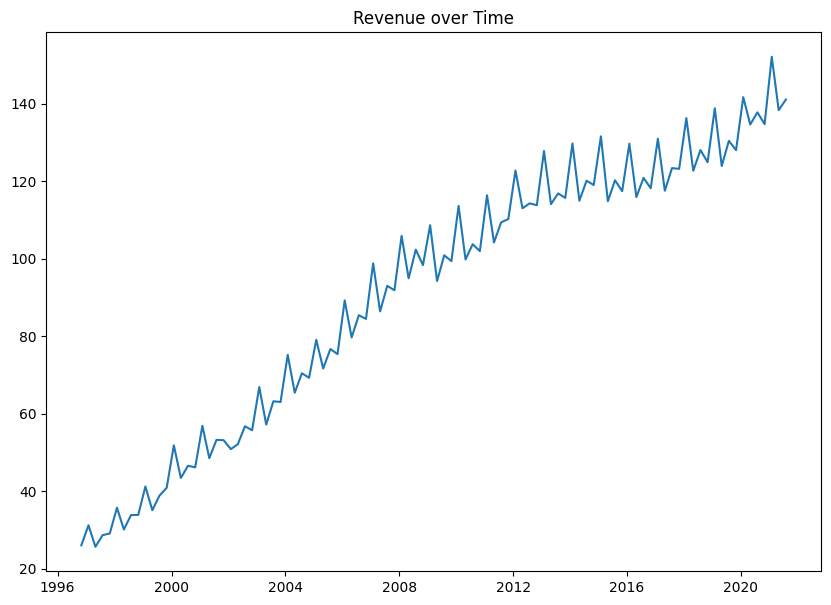

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.title("Revenue over Time")
plt.plot(df["New Date"], df["Value"])

## Date Pre-Processing

In [77]:
# Because COVID affectd the seasonal trends in 2019 -> Let's only look at data pre 2019
df = df[df["New Date"].dt.year < 2019]


In [78]:
df.columns

Index(['Date', 'Value', 'New Date'], dtype='object')

In [79]:
data = df["Value"]

train = data[:-8].values.reshape(-1,1)
test = data[-8:].values.reshape(-1, 1)

In [80]:
# Linearlly Scale the Features between (0,1) -> Does not reduce effect of outliers

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)


In [81]:
# Convert to pytorch tensor
import torch
train_scaled = torch.FloatTensor(train_scaled)
print(f"Original Dimensions: {train_scaled.shape}")
train_scaled = train_scaled.reshape((-1, ))

Original Dimensions: torch.Size([81, 1])


In [82]:
print(f"New Dimensions : {train_scaled.shape}")

New Dimensions : torch.Size([81])


## Create Model

We need to procure a supervised model which uses a set number of data points as examples then attempts to predict the next N number of data points.
- We will use the (x,y) pairs of sizes (16,8)

In [83]:
# Create X and y datapoints
train_periods = 16 # Number of data points in X
pred_periods = 8 # Number of data points in y

# Number of (X,y) pairs created from dataset
num_examples = range(len(train_scaled) - train_periods - pred_periods)

X_train = [train_scaled[i:i+train_periods] for i in num_examples]
y_train = [train_scaled[i+train_periods:i+train_periods+pred_periods] for i in num_examples]

# Convert Back to Torch Tensors
X_train = torch.stack(X_train)
y_train = torch.stack(y_train)

print(X_train.shape)
print(y_train.shape)

torch.Size([57, 16])
torch.Size([57, 8])


Inputs : Hidden State and New Data Point

Remember the overall process of LSTM is as follows
- Forget Gate : Determines what parts of the cell state are useful
- New Memory Network and Input Gate : Generates a update vector which is filtered by the input gate to determine which components of update vector are worth retaining
- Output Gate : Decide on the new hidden state by generating a filter vector to be used over the cell state

See the PyTorch documentation for `nn.LSTM`

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [98]:
# Create Model
from torch import nn

class LSTM(nn.Module):
  """
  input_size - Will be 1 in this example since we only have 1 predictor
  hidden_size - Can be chosen to dictate how much hidden "long-term" memory network has
  output_sdize - Equals the pred_periods or num of data points in y
  """

  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden=None):
    if hidden is None:
      self.hidden = (torch.zeros(1, 1, self.hidden_size).to(device),
                     torch.zeros(1,1, self.hidden_size).to(device))

    else:
      self.hidden = hidden

    # Gets the hidden and cell state
    lstm_out, self.hidden = self.lstm(x.view(len(x), 1, -1),
                                      self.hidden)

    predictions = self.linear(lstm_out.view(len(x), -1))

    return predictions[-1], self.hidden


The model takes 3 different inputs
- **input_siuze** : Number of predictor features we are using ( in our case we are only using 1 which is the revenue )
- **hidden_size** : The dimension of hidden and cell state
- **output_size** The output of the LSTM which must be converted using a linear layer. In our case we want the next 8 predicted revenue values

Our model will output both the predictions and the hidden state. While we will not use the hidden state but can be useful if you need to make further predictions while retaining previous context at a given point in time

In [99]:
# Initialize optimizer and criterion (loss function)

# Hidden size is a hyperparameter than can be tuned
model = LSTM(input_size=1, hidden_size=50, output_size=8)
criterion = nn.MSELoss() # Working with continuous data
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.001)


We will follow a standard training proceedure for supervised machine learning models
- Define number of epochs - how many times the training procedure will use the entire dataset
- For each (*x,y*) pair, calculate the predicted $\hat{y}$.
- Compute the loss (MSE) between $\hat{y}$ and y
- Compute the gradients of the parameters in the model
- Update the parameters using optimizer

In [100]:
## Train Model
from tqdm.auto import tqdm

epochs = 200
model.train()
model.to(device)

for epoch in tqdm(range(epochs), desc="Training"):

  # Going Through Each "Batch"
  for X, y in zip(X_train, y_train):
    X, y = X.to(device), y.to(device)
    y_preds, _ = model(X, None)
    loss = criterion(y_preds, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Print output
  if epoch % 5 == 0:
    print(f"Epoch : {epoch} | Loss : {loss:.4f}")


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 0 | Loss : 0.0072
Epoch : 5 | Loss : 0.0052
Epoch : 10 | Loss : 0.0049
Epoch : 15 | Loss : 0.0035
Epoch : 20 | Loss : 0.0045
Epoch : 25 | Loss : 0.0044
Epoch : 30 | Loss : 0.0043
Epoch : 35 | Loss : 0.0042
Epoch : 40 | Loss : 0.0040
Epoch : 45 | Loss : 0.0038
Epoch : 50 | Loss : 0.0032
Epoch : 55 | Loss : 0.0032
Epoch : 60 | Loss : 0.0033
Epoch : 65 | Loss : 0.0033
Epoch : 70 | Loss : 0.0031
Epoch : 75 | Loss : 0.0022
Epoch : 80 | Loss : 0.0016
Epoch : 85 | Loss : 0.0017
Epoch : 90 | Loss : 0.0014
Epoch : 95 | Loss : 0.0013
Epoch : 100 | Loss : 0.0013
Epoch : 105 | Loss : 0.0011
Epoch : 110 | Loss : 0.0009
Epoch : 115 | Loss : 0.0011
Epoch : 120 | Loss : 0.0004
Epoch : 125 | Loss : 0.0014
Epoch : 130 | Loss : 0.0005
Epoch : 135 | Loss : 0.0005
Epoch : 140 | Loss : 0.0004
Epoch : 145 | Loss : 0.0001
Epoch : 150 | Loss : 0.0010
Epoch : 155 | Loss : 0.0005
Epoch : 160 | Loss : 0.0005
Epoch : 165 | Loss : 0.0013
Epoch : 170 | Loss : 0.0006
Epoch : 175 | Loss : 0.0002
Epoch : 180 | 

## Make Predictiosn and Visualize Results

In [101]:
import numpy as np
model.eval()

# Predict the next 8 datapoints with the "most recent" data
with torch.inference_mode():
  predictions, _ = model(train_scaled[-16:].to(device), None)

predictions = scaler.inverse_transform(np.array(predictions.detach().cpu().numpy().reshape(-1, 1)))


In [102]:
print(predictions)

[[130.43654]
 [117.02057]
 [120.44472]
 [118.4047 ]
 [132.04243]
 [118.42523]
 [121.64483]
 [119.15221]]


By comparing the predicted (red) to the true (blue) we can see the model picking up the seasonal trends. The predictiosn seem to be lower than acutal, but can be explained by examining the previous data points.

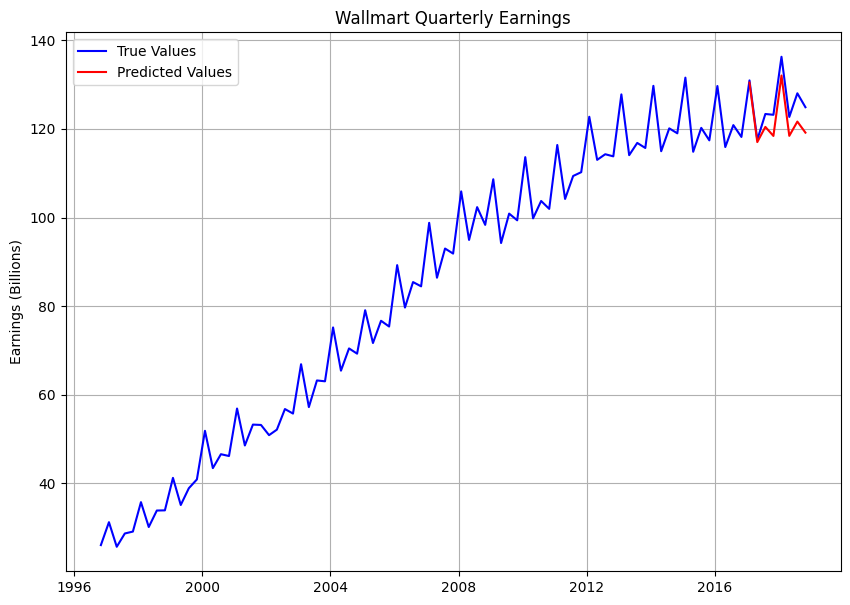

In [103]:
# Visualize the results

x = df["New Date"]

plt.figure(figsize=(10,7))
plt.title("Wallmart Quarterly Earnings")
plt.ylabel("Earnings (Billions)")
plt.grid(True)

plt.plot(x,
        df["Value"],
        "b-",
         label="True Values")

plt.plot(x[-len(predictions):],
         predictions,
         "r-",
         label="Predicted Values")

plt.legend()

